# Fitting the data: Part 2

In this tutorial we'll make use of a data generator with multiple model support, and its respective fitter class.

## Quick recap

#. Generation of data involves the **distributions** classes.
#. In case of multi-modal data, the **generators** module can be used with `multi_base` or `multi_{DISTRIBUTION}` function.
#. The **fitter** module contains pre-defined fitters for $-$ fitting the data.

## Custom data generation

To generate data using multiple models, e.g., `GaussianDistribution` + `LaplaceDistribution` we can make use of the `multiple_model` function from the **generators** module.

In [1]:
import numpy as np

from pymultifit.generators import multiple_models

fs = 14

Suppose the data follows,
$$
\mathcal{N}(20, -20, 2) + \mathcal{N}(4, -5.5, 10) + \mathcal{L}(5, -1, 0.5) + \mathcal{L}(10, 3, 1) + \mathcal{N}(4, 15, 3)
$$

where $\mathcal{N}$ is the **Gaussian** and $\mathcal{L}$ is the **Laplace** distribution, with their distributions defined as,

$$
\mathcal{N}(x; \mu, \sigma) = A\exp\left[-\frac{1}{2}\left(\frac{x - \mu}{\sigma}\right)^2\right]
$$
and
$$
\mathcal{L}(x;\mu, b) = A\exp\left(-\frac{|x - \mu|}{b}\right)
$$

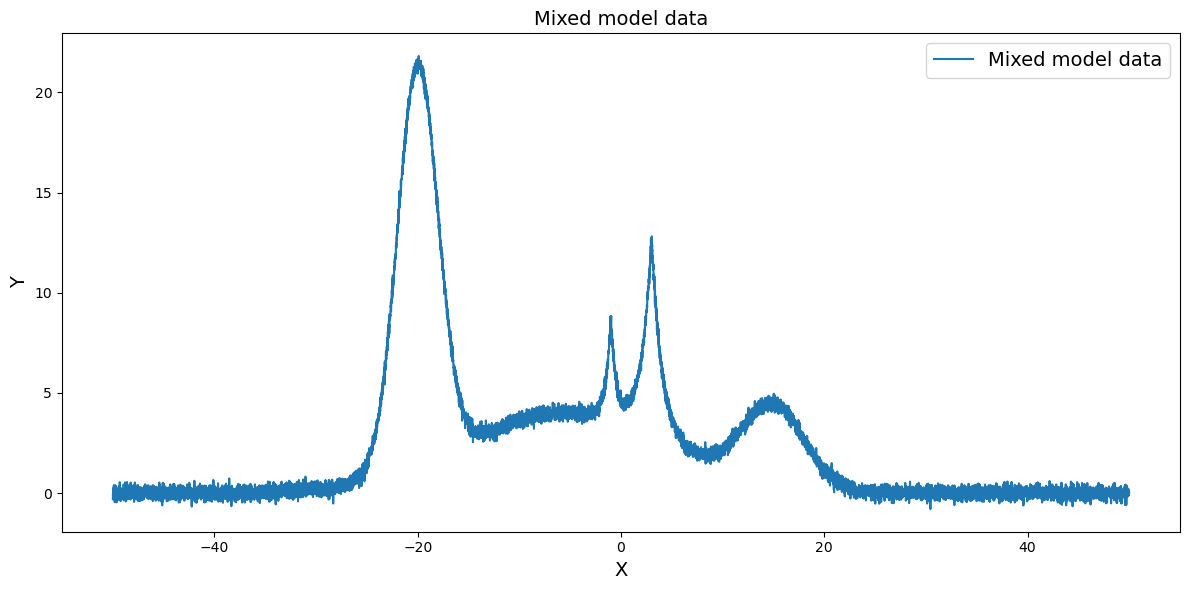

In [2]:
from matplotlib import pyplot as plt

x = np.linspace(-50, 50, 10_000)
parameters = [(20, -20, 2), (4, -5.5, 10), (5, -1, 0.5), (10, 3, 1), (4, 15, 3)]
y_mixed = multiple_models(x, params=parameters,
                          model_list=['gaussian'] * 2 + ['laplace'] * 2 + ['gaussian'], noise_level=0.2)

plt.figure(figsize=(12, 6))
plt.plot(x, y_mixed, label='Mixed model data')
plt.xlabel('X', fontsize=fs)
plt.ylabel('Y', fontsize=fs)
plt.title('Mixed model data', fontsize=fs)
plt.legend(loc='best', fontsize=fs)
plt.tight_layout()
plt.show()

Let's break down what's happening here,

1. The parameters are defined in a `list of tuple of floats`
2. The models corresponding to those parameters are given as a list of strings, `['gaussian'] * 2 + ['laplace'] * 2 + ['gaussian']` 
    - The first set of parameters belong to a gaussian distribution
    - The second and third set of parameters belong to a laplace distribution
    - The fourth set of parameters belong to another gaussian distribution
    - The list of models can also be passed as a single list, `['gaussian', 'gaussian', 'laplace', 'laplace', 'gaussian']` and it'll work the same.
3. A noise level of 0.2 is passed so that some amount of noise is added to the generated data
4. Plotting the generated data using `matplotlib`

## Custom data fitting

For this kind of data where data is in mixed form, `pyMultiFit` introduces a powerful class `MixedDataFitter`.
The name implies, it can fit data with mixed distributions, so let's first import it

In [3]:
from pymultifit.fitters import MixedDataFitter

As with all the fitters, it needs,

- `x_values`: The x-values for the data.
- `y_values`: The y-values for the data.
- `max_iterations`: The max number of iterations for fitting procedure.

But it requires one mandatory and one optional additional parameter,

- `model_list` (required): List of models to fit (e.g., `['gaussian', 'gaussian', 'line']`).
- `fitter_dictionary` (optional): A dictionary for mapping the model names to the model fitter classes, (more on this later on).

The `fitter_dicitonary` gives this class the ability to adapt to any function provided given that its fitter implementation is present in the dictionary.
Internally, the class can handle all the fitters defined in the library, and the user provided `fitter_dictionary` overrides this functionality.

In [4]:
mxf = MixedDataFitter(x, y_mixed, ['gaussian', 'gaussian', 'laplace', 'laplace', 'gaussian'])

Taking into consideration that the user might feel ambiguous about calling `'gaussian'` vs `'normal'` the `pyMultiFit` has safeguards at string values.
One can call, `GAUSSIAN`, `LAPLACE` from the `pyMultiFit` module to remove any responsibility of spell errors,

In [5]:
from pymultifit import GAUSSIAN, LAPLACE, NORMAL

mxf2 = MixedDataFitter(x_values=x, y_values=y_mixed, model_list=[GAUSSIAN, NORMAL, LAPLACE, LAPLACE, GAUSSIAN])

With our fitter set, we can now make guesses and try to fit the data

In [6]:
amplitudes = [20, 4, 5, 10, 5]
mean = [-20, -6, -1, 2, 15]
std = [2, 8, 0.3, 0.4, 5]

guess = np.column_stack([amplitudes, mean, std])

Note that the `column_stack` only works when the number of parameters in each fitter model is the same. 
In case this is not possible, for example `GaussianFitter` (3 parameters) and `SkewNormalFitter` (4 parameters), the user is advised to define the guesses in lists of tuples.

```python
# first tuple represents Guassian parameters, second one represents SkewNormal parameters
guesses = [(20, -20, 2), (5, -3, -2, 3)]
```

Now, we pass the `guess` parameter to our fitter

<Axes: title={'center': '5 MixedDataFitter fit'}, xlabel='X', ylabel='Y'>

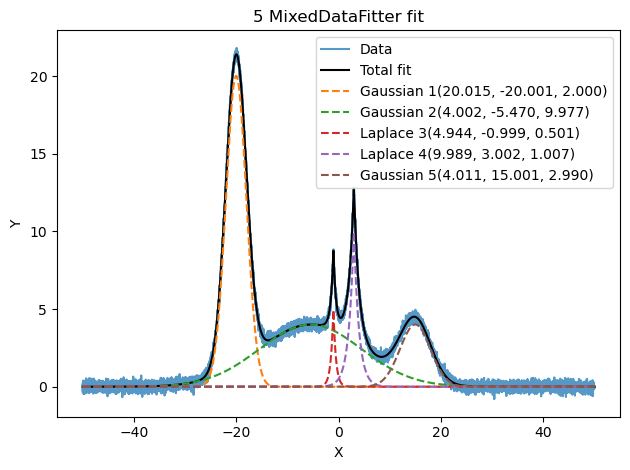

In [7]:
mxf2.fit(p0=guess)
mxf2.plot_fit(show_individuals=True)

And the data is fitted perfectly, and each fitter's parameters are also being displayed in the legend.

## Exploring the fitted data

Now that we've fitted the data, we want to get the parameters for the fitted values.
For this, we can use the handy `get_parameters` function

In [8]:
fitted_parameters = mxf2.get_model_parameters()
print(fitted_parameters)

{'gaussian': [array([ 20.01470128, -20.00087787,   2.00000381]), array([ 4.00240839, -5.47010802,  9.97681257]), array([ 4.0110528 , 15.00083366,  2.98957942])], 'laplace': [array([ 4.94391565, -0.99947453,  0.50076247]), array([9.98908551, 3.00208333, 1.00674954])]}


We see here that the `get_model_parameters()` function gives the output in form of a dictionary, each model is a key, which has N number of parameters attached to it.
In order to get only the values for `GAUSSIAN` model, we can tell the function to fetch only that.

In [9]:
gaussian_values = mxf2.get_model_parameters(model=GAUSSIAN)
print(gaussian_values)

[array([ 20.01470128, -20.00087787,   2.00000381]), array([ 4.00240839, -5.47010802,  9.97681257]), array([ 4.0110528 , 15.00083366,  2.98957942])]


If the errors values are required, we can simply pass `True` to the `get_errors` keyword. 

In [10]:
dict_ = mxf2.get_model_parameters(model=GAUSSIAN, errors=True)

values = dict_['parameters']
errors = dict_['errors']

stacked = np.dstack([values, errors])

for i in range(3):
    print(f'Gaussian {i + 1}\n', stacked[:, i, :])

Gaussian 1
 [[2.00147013e+01 1.52205083e-02]
 [4.00240839e+00 7.58011066e-03]
 [4.01105280e+00 1.25764491e-02]]
Gaussian 2
 [[-2.00008779e+01  1.51446995e-03]
 [-5.47010802e+00  3.78737748e-02]
 [ 1.50008337e+01  1.07659295e-02]]
Gaussian 3
 [[2.00000381e+00 1.91619599e-03]
 [9.97681257e+00 3.53736213e-02]
 [2.98957942e+00 1.24029423e-02]]


Now we have both the parameters, and the errors of the fitted function and their parameters respectively.